# Data

## Load the data

In [34]:
"""
    Download and save raw market data CSV
"""

import pandas as pd
import logging
import os

# Setup Logger
logging.basicConfig(level=logging.INFO, format="%(asctime)s | %(levelname)s | %(message)s", handlers=[logging.StreamHandler()])
logger = logging.getLogger(__name__)

# Download and save CSV. One time only
logger.info("Downloading power data...")
url = "https://data.open-power-system-data.org/time_series/2020-10-06/time_series_60min_singleindex.csv"

df = pd.read_csv(url)
logger.info("Saving to data/power_data_raw.csv")
os.makedirs("data", exist_ok=True)
df.to_csv("data/power_data_raw.csv", index=False)

logger.info("Process completed.")

2025-11-29 22:48:30,775 | INFO | Downloading power data...
2025-11-29 22:48:54,386 | INFO | Saving to data/power_data_raw.csv
2025-11-29 22:48:57,781 | INFO | Process completed.


## Get Austria's Values

In [35]:
df = pd.read_csv("data/power_data_raw.csv")
print(df.head())
with open("data/all_column_names.txt", "w") as f:
    for col in df.columns:
        f.write(f"{col}\n")

          utc_timestamp        cet_cest_timestamp  \
0  2014-12-31T23:00:00Z  2015-01-01T00:00:00+0100   
1  2015-01-01T00:00:00Z  2015-01-01T01:00:00+0100   
2  2015-01-01T01:00:00Z  2015-01-01T02:00:00+0100   
3  2015-01-01T02:00:00Z  2015-01-01T03:00:00+0100   
4  2015-01-01T03:00:00Z  2015-01-01T04:00:00+0100   

   AT_load_actual_entsoe_transparency  AT_load_forecast_entsoe_transparency  \
0                                 NaN                                   NaN   
1                              5946.0                                6701.0   
2                              5726.0                                6593.0   
3                              5347.0                                6482.0   
4                              5249.0                                6454.0   

   AT_price_day_ahead  AT_solar_generation_actual  \
0                 NaN                         NaN   
1                35.0                         NaN   
2                45.0                         N

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50401 entries, 0 to 50400
Columns: 300 entries, utc_timestamp to UA_load_forecast_entsoe_transparency
dtypes: float64(298), object(2)
memory usage: 115.4+ MB


In [ ]:
at_cols = df.columns[df.columns.str.startswith("AT_")]
selected_cols = ["utc_timestamp"] + list(at_cols) # Desired Columns
df_selected = df[selected_cols].copy()
df_selected = df_selected.drop(["AT_load_forecast_entsoe_transparency", "AT_solar_generation_actual", "AT_load_forecast_entsoe_transparency"], axis=1)
df_selected["utc_timestamp"] = pd.to_datetime(df["utc_timestamp"]) # Datetime Timestamp
df_selected = df_selected.set_index("utc_timestamp") # Timestamp as index
print(df_selected.head(1))

                           AT_load_actual_entsoe_transparency  \
utc_timestamp                                                   
2014-12-31 23:00:00+00:00                                 NaN   

                           AT_price_day_ahead  \
utc_timestamp                                   
2014-12-31 23:00:00+00:00                 NaN   

                           AT_wind_onshore_generation_actual  
utc_timestamp                                                 
2014-12-31 23:00:00+00:00                                NaN  


### Enforce Frequency and Clean Dataset

#### Enforce Frequency

In [38]:
full_idx = pd.date_range(
    start=df_selected.index.min(),
    end=df_selected.index.max(),
    freq="h",
    tz=df_selected.index.tz
)
df_selected = df_selected.reindex(full_idx)

In [39]:
important_cols = ["AT_load_actual_entsoe_transparency", "AT_price_day_ahead", "AT_wind_onshore_generation_actual"]

In [40]:
first_valid_indices = df_selected[important_cols].apply(lambda col: col.first_valid_index())
last_valid_indices = df_selected[important_cols].apply(lambda col: col.last_valid_index())

print("First valid data points:")
print(first_valid_indices)

First valid data points:
AT_load_actual_entsoe_transparency   2015-01-01 00:00:00+00:00
AT_price_day_ahead                   2015-01-01 00:00:00+00:00
AT_wind_onshore_generation_actual    2015-01-01 00:00:00+00:00
dtype: datetime64[ns, UTC]


In [41]:
print(last_valid_indices)

AT_load_actual_entsoe_transparency   2020-09-30 23:00:00+00:00
AT_price_day_ahead                   2018-10-02 21:00:00+00:00
AT_wind_onshore_generation_actual    2020-09-30 23:00:00+00:00
dtype: datetime64[ns, UTC]


In [42]:
global_start = first_valid_indices.max()
global_end = last_valid_indices.min()

print(f"\nSlicing Data to Common Range: {global_start} to {global_end}")


Slicing Data to Common Range: 2015-01-01 00:00:00+00:00 to 2018-10-02 21:00:00+00:00


In [43]:
df_clean = df_selected.loc[global_start: global_end].copy()
print(df_clean.isna().sum())

AT_load_actual_entsoe_transparency     0
AT_price_day_ahead                    57
AT_wind_onshore_generation_actual     48
dtype: int64


In [44]:
def get_max_consecutive_nans(series):
    # Create a boolean mask where True is NaN
    mask = series.isna()
    # Group consecutive True/False values and count them
    # We only keep the groups that are NaN (True)
    consecutive_counts = mask.groupby((mask != mask.shift()).cumsum()).sum()
    # Return the max
    return consecutive_counts[mask.groupby((mask != mask.shift()).cumsum()).first()].max()

# Apply to your important columns
for col in important_cols:
    max_gap = get_max_consecutive_nans(df_clean[col])
    print(f"{col}: Max consecutive NaNs = {max_gap}")

AT_load_actual_entsoe_transparency: Max consecutive NaNs = nan
AT_price_day_ahead: Max consecutive NaNs = 24
AT_wind_onshore_generation_actual: Max consecutive NaNs = 24


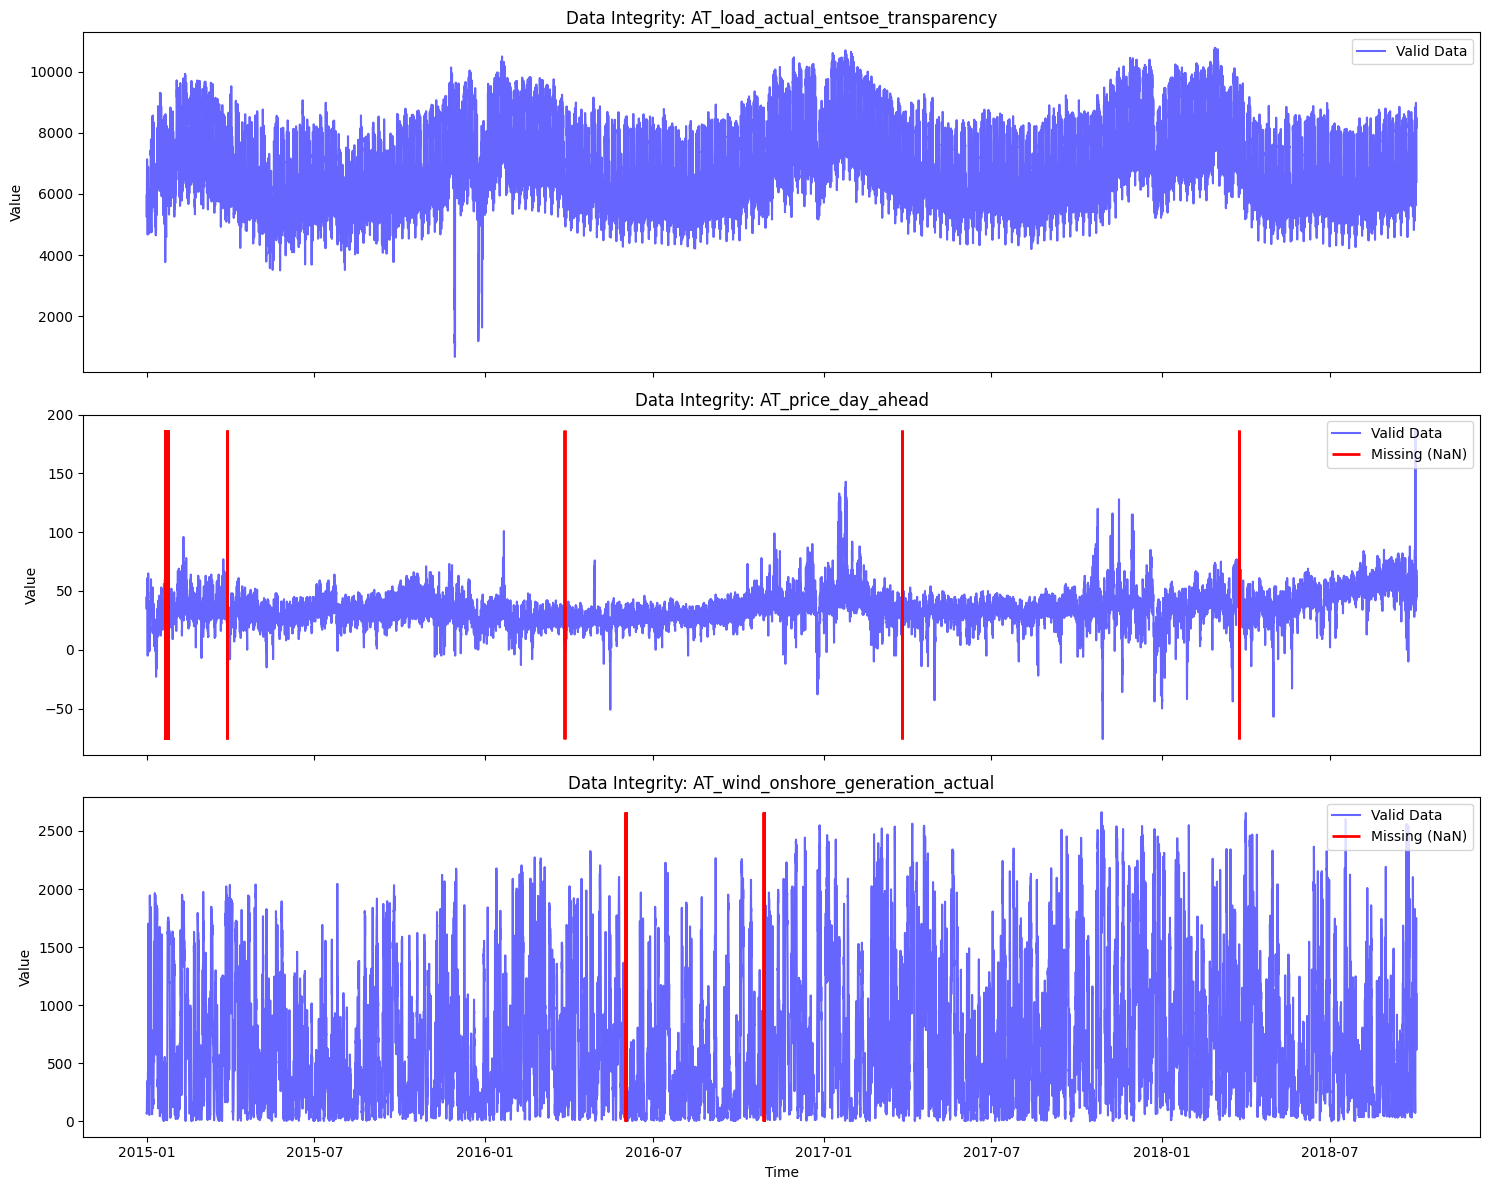

In [45]:
import matplotlib.pyplot as plt

# The columns we care about
cols_to_check = [
    'AT_load_actual_entsoe_transparency',
    'AT_price_day_ahead',
    'AT_wind_onshore_generation_actual'
]

# Create a figure with 3 subplots (one for each column)
fig, axes = plt.subplots(nrows=len(cols_to_check), ncols=1, figsize=(15, 12), sharex=True)

for i, col in enumerate(cols_to_check):
    # 1. Get data
    valid_data = df_clean[col]
    missing_data = df_clean[df_clean[col].isna()]
    
    # 2. Calculate ranges for plotting
    d_min = valid_data.min()
    d_max = valid_data.max()
    
    # 3. Plot Valid Data
    axes[i].plot(valid_data.index, valid_data, label="Valid Data", color="blue", alpha=0.6)
    
    # 4. Plot Missing Data (The Red Stripes)
    if len(missing_data) > 0:
        axes[i].vlines(
            x=missing_data.index, 
            ymin=d_min, 
            ymax=d_max, 
            colors="red", 
            linewidth=2, 
            label="Missing (NaN)"
        )
    
    axes[i].set_title(f"Data Integrity: {col}")
    axes[i].set_ylabel("Value")
    axes[i].legend(loc="upper right")

plt.xlabel("Time")
plt.tight_layout()
plt.show()

In [46]:
df_clean['AT_wind_onshore_generation_actual'] = pd.to_numeric(
    df_clean['AT_wind_onshore_generation_actual'], 
    errors='coerce'
)

In [47]:
df_clean[important_cols] = df_clean[important_cols].interpolate(method="linear", limit_direction="both")
print(df_clean.isna().sum())

AT_load_actual_entsoe_transparency    0
AT_price_day_ahead                    0
AT_wind_onshore_generation_actual     0
dtype: int64


## Feature Engineering

### Lagged price (previous hour)

In [48]:
df_clean["AT_price_day_ahead_lag1"] = df_clean["AT_price_day_ahead"].shift(1)

### 24-hour SMA and 24-hour EMA for load

In [49]:
df_clean["AT_load_rolling24h"] = df_clean["AT_load_actual_entsoe_transparency"].rolling(window=24).mean()
df_clean["AT_load_ema24h"] = df_clean["AT_load_actual_entsoe_transparency"].ewm(span=24, adjust=False).mean()

### Hour and weekday

In [50]:
df_clean["hour"] = df_clean.index.hour
df_clean["weekday"] = df_clean.index.dayofweek

In [54]:
df_clean.head(30)

,AT_load_actual_entsoe_transparency,AT_price_day_ahead,AT_wind_onshore_generation_actual,AT_price_day_ahead_lag1,AT_load_rolling24h,AT_load_ema24h,hour,weekday
2015-01-01 00:00:00+00:00,5946.0,35.0,69.0,NaN,NaN,5946.000000,0,3
2015-01-01 01:00:00+00:00,5726.0,45.0,64.0,35.0,NaN,5928.400000,1,3
2015-01-01 02:00:00+00:00,5347.0,41.0,65.0,45.0,NaN,5881.888000,2,3
2015-01-01 03:00:00+00:00,5249.0,38.0,64.0,41.0,NaN,5831.256960,3,3
2015-01-01 04:00:00+00:00,5309.0,35.0,64.0,38.0,NaN,5789.476403,4,3
2015-01-01 05:00:00+00:00,5574.0,35.0,84.0,35.0,NaN,5772.238291,5,3
2015-01-01 06:00:00+00:00,5925.0,36.0,131.0,35.0,NaN,5784.459228,6,3
2015-01-01 07:00:00+00:00,6343.0,36.0,109.0,36.0,NaN,5829.142489,7,3
2015-01-01 08:00:00+00:00,6882.0,41.0,146.0,36.0,NaN,5913.371090,8,3
2015-01-01 09:00:00+00:00,6963.0,45.0,146.0,41.0,NaN,5997.341403,9,3


In [52]:
df_clean.tail(30)

,AT_load_actual_entsoe_transparency,AT_price_day_ahead,AT_wind_onshore_generation_actual,AT_price_day_ahead_lag1,AT_load_rolling24h,AT_load_ema24h,hour,weekday
2018-10-01 16:00:00+00:00,8823.0,73.0,1177.0,66.0,7262.375000,7622.682068,16,0
2018-10-01 17:00:00+00:00,8517.0,187.0,1263.0,73.0,7334.416667,7694.227503,17,0
2018-10-01 18:00:00+00:00,7968.0,75.0,1324.0,187.0,7394.208333,7716.129303,18,0
2018-10-01 19:00:00+00:00,7203.0,67.0,1269.0,75.0,7441.291667,7675.078958,19,0
2018-10-01 20:00:00+00:00,6836.0,59.0,1150.0,67.0,7472.333333,7607.952642,20,0
2018-10-01 21:00:00+00:00,6314.0,52.0,1221.0,59.0,7497.708333,7504.436430,21,0
2018-10-01 22:00:00+00:00,6026.0,38.0,1464.0,52.0,7520.208333,7386.161516,22,0
2018-10-01 23:00:00+00:00,5792.0,38.0,1316.0,38.0,7542.375000,7258.628595,23,0
2018-10-02 00:00:00+00:00,5698.0,37.0,1201.0,38.0,7563.250000,7133.778307,0,1
2018-10-02 01:00:00+00:00,5629.0,33.0,1337.0,37.0,7584.416667,7013.396043,1,1


In [55]:
df_model = df_clean.dropna()
df_model.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 32879 entries, 2015-01-01 23:00:00+00:00 to 2018-10-02 21:00:00+00:00
Freq: h
Data columns (total 8 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   AT_load_actual_entsoe_transparency  32879 non-null  float64
 1   AT_price_day_ahead                  32879 non-null  float64
 2   AT_wind_onshore_generation_actual   32879 non-null  float64
 3   AT_price_day_ahead_lag1             32879 non-null  float64
 4   AT_load_rolling24h                  32879 non-null  float64
 5   AT_load_ema24h                      32879 non-null  float64
 6   hour                                32879 non-null  int32  
 7   weekday                             32879 non-null  int32  
dtypes: float64(6), int32(2)
memory usage: 2.0 MB


# Modeling

## Training

### Split the data

In [18]:
split_point = int(len(df_model) * 0.8)
train = df_model.iloc[:split_point]
test = df_model.iloc[split_point:]

### Linear regression

#### Training

In [19]:
from sklearn.linear_model import LinearRegression

X_train = train[["AT_price_day_ahead_lag1", "AT_load_actual_entsoe_transparency", "AT_load_rolling24h", "AT_wind_onshore_generation_actual", "hour", "weekday"]]
y_train = train["AT_price_day_ahead"]
model = LinearRegression()
model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


#### Testing

In [20]:
X_test = test[["AT_price_day_ahead_lag1", "AT_load_actual_entsoe_transparency", "AT_load_rolling24h", "AT_wind_onshore_generation_actual", "hour", "weekday"]]
y_test = test["AT_price_day_ahead"]

y_pred = model.predict(X_test) # Test part
y_train_pred = model.predict(X_train) # Train part

#### Calculate error metrics

In [21]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

In [22]:
print("MAE:", mean_absolute_error(y_train, y_train_pred)) # Train error
print("RMSE:", root_mean_squared_error(y_train, y_train_pred))

MAE: 2.774551827768339
RMSE: 3.90056853277003


In [23]:
print("MAE:", mean_absolute_error(y_test, y_pred)) # Prediction error
print("RMSE:", root_mean_squared_error(y_test, y_pred))

MAE: 3.25549129365974
RMSE: 4.8022267928895745


In [24]:
print(y_test)

utc_timestamp
2018-01-02 07:00:00+00:00    39.0
2018-01-02 08:00:00+00:00    44.0
2018-01-02 09:00:00+00:00    40.0
2018-01-02 10:00:00+00:00    41.0
2018-01-02 11:00:00+00:00    41.0
                             ... 
2018-10-02 17:00:00+00:00    68.0
2018-10-02 18:00:00+00:00    65.0
2018-10-02 19:00:00+00:00    54.0
2018-10-02 20:00:00+00:00    45.0
2018-10-02 21:00:00+00:00    62.0
Name: AT_price_day_ahead, Length: 6565, dtype: float64


In [25]:
print(y_pred)

[38.01040372 40.84637166 45.3335686  ... 61.0872018  50.31109794
 41.20919478]


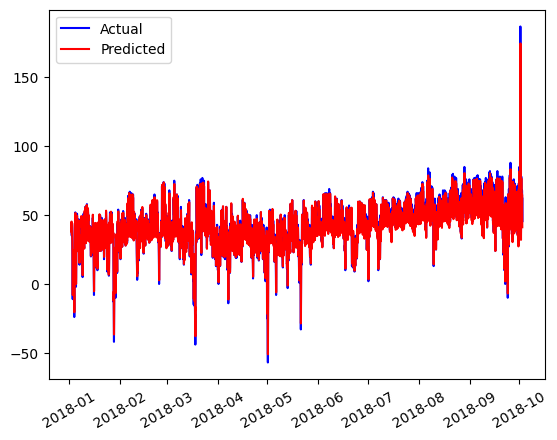

In [26]:
plt.plot(test.index, y_test, label="Actual", color="blue")
plt.plot(test.index, y_pred, label="Predicted", color="red")
plt.xticks(rotation=30)
plt.legend()
plt.show()

### Cross-validation way

In [27]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, make_scorer, root_mean_squared_error

In [28]:
X = df_model[["AT_price_day_ahead_lag1", "AT_load_actual_entsoe_transparency", "AT_load_ema24h", "AT_wind_onshore_generation_actual", "hour", "weekday"]]
y = df_model["AT_price_day_ahead"]

In [29]:
tscv = TimeSeriesSplit(n_splits=5) # Split the data into 5 folds
model = LinearRegression()

In [30]:
scores = cross_val_score(
    model, X, y, cv=tscv,
    scoring=make_scorer(mean_squared_error, greater_is_better=False)
)

In [31]:
import numpy as np
rmse_scores = np.sqrt(-scores)
print("RMSE scores for each fold:", rmse_scores)
print("Mean RMSE:", rmse_scores.mean())
print("Std RMSE:", rmse_scores.std())

RMSE scores for each fold: [3.44707379 3.1366749  4.48398893 4.32078087 4.93825284]
Mean RMSE: 4.0653542672367164
Std RMSE: 0.670397756659311


### Manual CV to plot the most representative fold

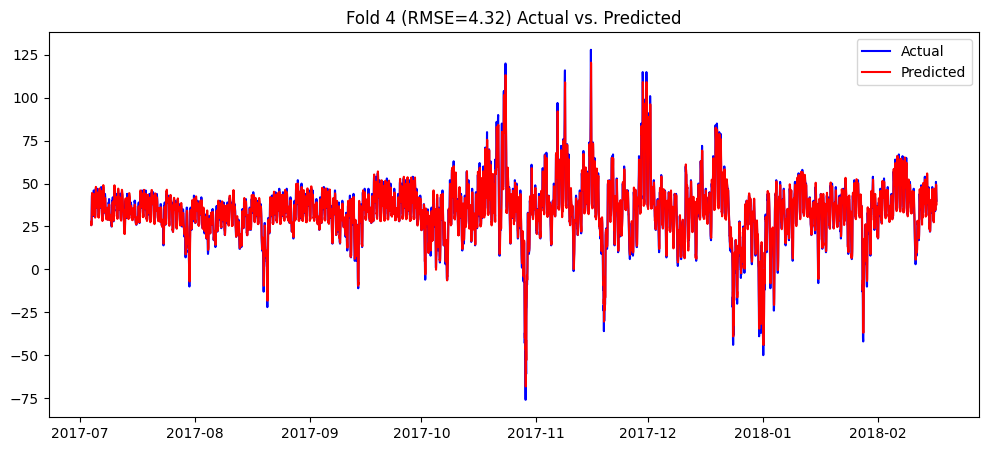

In [32]:
X_cv_plot = df_model[["AT_price_day_ahead_lag1", "AT_load_actual_entsoe_transparency", "AT_load_ema24h", "AT_wind_onshore_generation_actual", "hour", "weekday"]]
y_cv_plot = df_model["AT_price_day_ahead"]

tscv_plot = TimeSeriesSplit(n_splits=5)
model_cv_plot = LinearRegression()

fold_rmse = []
fold_preds = []
fold_indices = []

for train_idx, test_idx in tscv_plot.split(X_cv_plot):
    model_cv_plot.fit(X_cv_plot.iloc[train_idx], y_cv_plot.iloc[train_idx])
    y_pred_fold = model_cv_plot.predict(X.iloc[test_idx])
    rmse = root_mean_squared_error(y_cv_plot.iloc[test_idx], y_pred_fold)
    fold_rmse.append(rmse)
    fold_preds.append(y_pred_fold)
    fold_indices.append(test_idx)

mean_rmse = np.mean(fold_rmse)
best_fold = np.argmin(np.abs(np.array(fold_rmse) - mean_rmse))

plt.figure(figsize=(12, 5))
plt.plot(y_cv_plot.iloc[fold_indices[best_fold]].index, y.iloc[fold_indices[best_fold]], label="Actual", color="blue")
plt.plot(y_cv_plot.iloc[fold_indices[best_fold]].index, fold_preds[best_fold], label="Predicted", color="red")
plt.title(f"Fold {best_fold+1} (RMSE={fold_rmse[best_fold]:.2f}) Actual vs. Predicted")
plt.legend()
plt.show()

### Coefficients

#### Raw Coefficients

In [33]:
for feature, coeff in zip(["AT_price_day_ahead_lag1", "AT_load_actual_entsoe_transparency", "AT_load_ema24h", "AT_wind_onshore_generation_actual", "hour", "weekday"], model_cv_plot.coef_):
    print(f"{feature}: {coeff}")

AT_price_day_ahead_lag1: 0.9252642296534156
AT_load_actual_entsoe_transparency: 0.00148447979339983
AT_load_ema24h: -0.0012850055699675069
AT_wind_onshore_generation_actual: -0.0001230859300456718
hour: -0.12249617207266901
weekday: 0.028069213027160502


#### Normalized Coefficients

In [34]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LinearRegression()
model.fit(X_train_scaled, y_train)

for feature, coeff in zip(X_train.columns, model.coef_):
    print(f"{feature}: {coeff}")

AT_price_day_ahead_lag1: 12.823294761126467
AT_load_actual_entsoe_transparency: 1.696579052463579
AT_load_rolling24h: -0.7458099051035761
AT_wind_onshore_generation_actual: -0.10571853512554606
hour: -1.0363762106252374
weekday: 0.05922149419434316


## ARIMA

### Static Forecasting Method

In [35]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 32822 entries, 2015-01-01 23:00:00+00:00 to 2018-10-02 21:00:00+00:00
Data columns (total 8 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   AT_load_actual_entsoe_transparency  32822 non-null  float64
 1   AT_price_day_ahead                  32822 non-null  float64
 2   AT_wind_onshore_generation_actual   32822 non-null  float64
 3   AT_price_day_ahead_lag1             32822 non-null  float64
 4   AT_load_rolling24h                  32822 non-null  float64
 5   AT_load_ema24h                      32822 non-null  float64
 6   hour                                32822 non-null  int32  
 7   weekday                             32822 non-null  int32  
dtypes: float64(6), int32(2)
memory usage: 2.0 MB


In [36]:
from statsmodels.tsa.arima.model import ARIMA

In [37]:
weeks_to_test = 2
hours_to_test = 24 * 7 * weeks_to_test

In [38]:
series = df_model["AT_price_day_ahead"]

train_arima, test_arima = series[:-hours_to_test], series[-hours_to_test:]

In [39]:
# Create a complete hourly index (using your min/max dates and timezone)
train_hourly_index = pd.date_range(
    start=train_arima.index.min(),
    end=train_arima.index.max(),
    freq="h",
    tz=train_arima.index.tz
)

test_hourly_index = pd.date_range(
    start=test_arima.index.min(),
    end=test_arima.index.max(),
    freq="h",
    tz=test_arima.index.tz
)

# Reindex your series to the train hourly index
train_arima_regular = train_arima.reindex(train_hourly_index)
test_arima_regular = test_arima.reindex(test_hourly_index)

# Fill gaps: interpolate
train_arima_regular = train_arima_regular.interpolate()    # linear interpolation
test_arima_regular = test_arima_regular.interpolate()

# Now it is fully regular: freq == 'H', ready for ARIMA and time series models
print(train_arima_regular.index.freq)
print(train_arima_regular.head(10))


<Hour>
2015-01-01 23:00:00+00:00    15.0
2015-01-02 00:00:00+00:00     9.0
2015-01-02 01:00:00+00:00     5.0
2015-01-02 02:00:00+00:00    -5.0
2015-01-02 03:00:00+00:00    -4.0
2015-01-02 04:00:00+00:00    -4.0
2015-01-02 05:00:00+00:00     9.0
2015-01-02 06:00:00+00:00    26.0
2015-01-02 07:00:00+00:00    36.0
2015-01-02 08:00:00+00:00    42.0
Freq: h, Name: AT_price_day_ahead, dtype: float64


In [40]:
print(train_arima_regular.index.is_monotonic_increasing)
print(train_arima_regular.index.has_duplicates)
print(train_arima_regular.index.inferred_freq)
print(train_arima_regular.index.freq)

print(train_arima.head(10))

diffs = train_arima_regular.index.to_series().diff().value_counts()
print(diffs.head())

True
False
h
<Hour>
utc_timestamp
2015-01-01 23:00:00+00:00    15.0
2015-01-02 00:00:00+00:00     9.0
2015-01-02 01:00:00+00:00     5.0
2015-01-02 02:00:00+00:00    -5.0
2015-01-02 03:00:00+00:00    -4.0
2015-01-02 04:00:00+00:00    -4.0
2015-01-02 05:00:00+00:00     9.0
2015-01-02 06:00:00+00:00    26.0
2015-01-02 07:00:00+00:00    36.0
2015-01-02 08:00:00+00:00    42.0
Name: AT_price_day_ahead, dtype: float64
0 days 01:00:00    32542
Name: count, dtype: int64


In [41]:
model_arima = ARIMA(train_arima_regular, order=(5,1,4))
model_arima_fit = model_arima.fit()
print(model_arima_fit.summary())

/Users/petros/Projects/quant/quant_env/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:     AT_price_day_ahead   No. Observations:                32543
Model:                 ARIMA(5, 1, 4)   Log Likelihood              -83824.214
Date:                Tue, 25 Nov 2025   AIC                         167668.428
Time:                        00:07:38   BIC                         167752.331
Sample:                    01-01-2015   HQIC                        167695.245
                         - 09-18-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3963      0.020     19.717      0.000       0.357       0.436
ar.L2          1.1063      0.025     44.482      0.000       1.058       1.155
ar.L3         -0.6821      0.014    -48.704      0.0

In [42]:
# print(train_arima)
print(train_arima_regular.mean())

33.746151246043695


In [ ]:
in_smaple_preds_arima = model_arima_fit.predict()

rmse_arima = root_mean_squared_error(train_arima_regular, in_smaple_preds_arima)
mae_arima = mean_absolute_error(train_arima_regular, in_smaple_preds_arima)
print("RMSE: ", rmse_arima)
print("MAE: ", mae_arima)

RMSE:  3.1814977911528803
MAE:  2.1101935007759716


In [ ]:
out_sample_forecast_arima = model_arima_fit.forecast(steps=len(test_arima_regular))

rmse_test_arima = root_mean_squared_error(test_arima_regular, out_sample_forecast_arima)
mae_test_arima = mean_absolute_error(test_arima_regular, out_sample_forecast_arima)

print("RMSE: ", rmse_test_arima)
print("MAE: ", mae_test_arima)

RMSE:  15.213603780024116
MAE:  10.493368061614895


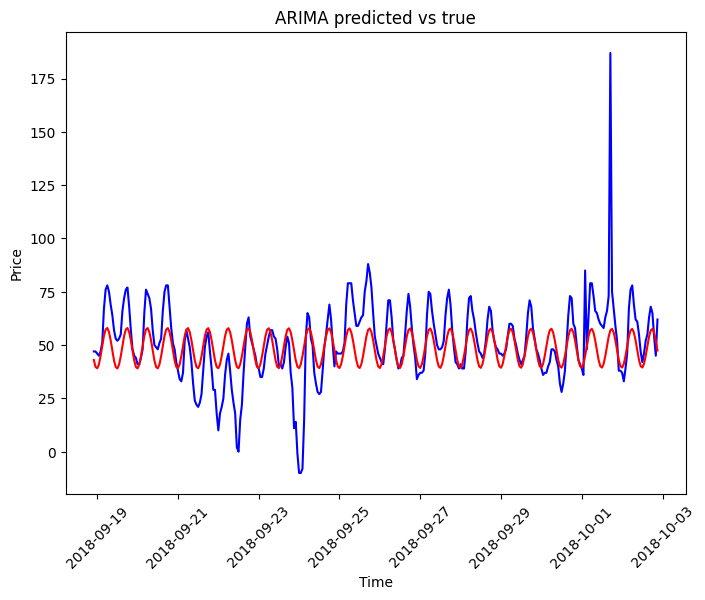

In [45]:
plt.figure(figsize=(8, 6))
plt.plot(test_arima_regular.index, test_arima_regular, color="blue")
plt.plot(test_arima_regular.index, out_sample_forecast_arima, color="red")
plt.xticks(rotation=45)
plt.xlabel("Time")
plt.ylabel("Price")
plt.title("ARIMA predicted vs true")
plt.show()

### Rolling Window Forecasting Method

In [ ]:
from pmdarima import auto_arima
auto_model = auto_arima(train_arima_regular, seasonal=False, trace=True)
print(auto_model.summary())
best_order = auto_model.order
# Fit ARIMA with best_order
model_arima = ARIMA(train_arima_regular, order=best_order).fit()
out_sample_forecast_arima = model_arima.forecast(steps=len(test_arima_regular))
out_sample_forecast_arima = pd.Series(out_sample_forecast_arima, index=test_arima_regular.index)


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=170880.641, Time=2.88 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=186404.670, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=174959.877, Time=0.24 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=176548.459, Time=0.61 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=186402.672, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=174008.158, Time=1.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=170901.959, Time=7.06 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=170860.691, Time=5.89 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=170879.030, Time=3.96 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=170880.754, Time=6.90 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=170834.079, Time=12.60 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=170871.997, Time=5.68 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=170851.929, Time=12.29 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=11.60 sec
 ARIMA(2,

/Users/petros/Projects/quant/quant_env/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/Users/petros/Projects/quant/quant_env/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Starting forecast for 336 hours...
Rolling Forecast RMSE: 16.81
Rolling Forecast MAE: 11.89


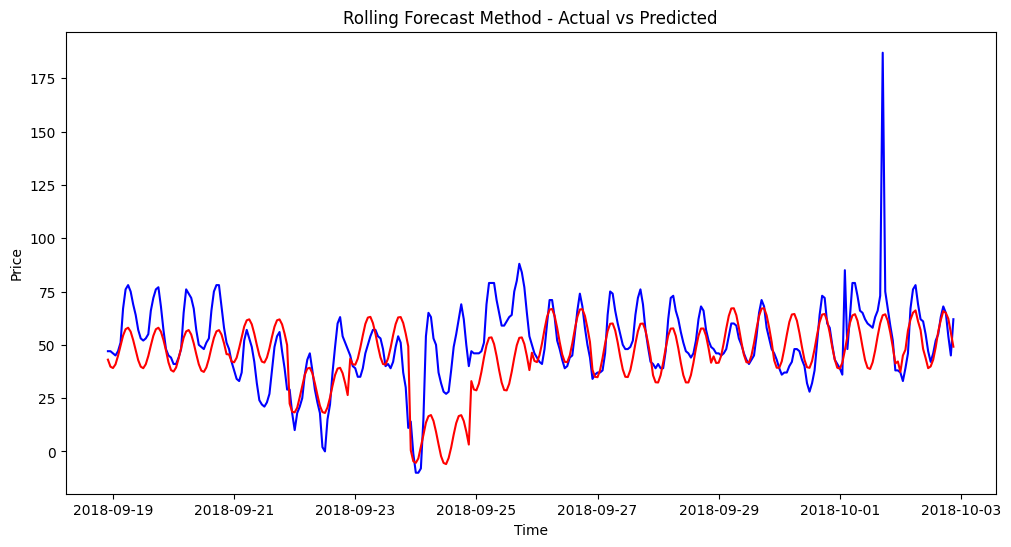

In [47]:
rolling_model = ARIMA(train_arima_regular, order=(5, 1, 4)).fit()

predictions = []
history = train_arima_regular.copy()
step_size = 24 # We iterate through the test data in steps of 24 hours (Day-Ahead)

print(f"Starting forecast for {len(test_arima_regular)} hours...")

for t in range(0, len(test_arima_regular), step_size):
    forecast = rolling_model.forecast(steps=step_size)

    predictions.extend(forecast)

    true_chunk = test_arima_regular[t: t + step_size]

    rolling_model = rolling_model.append(true_chunk, refit=False)

predictions = pd.Series(predictions, index=test_arima_regular.index)

rmse = root_mean_squared_error(test_arima_regular, predictions)
mae = mean_absolute_error(test_arima_regular, predictions)

print(f"Rolling Forecast RMSE: {rmse:.2f}")
print(f"Rolling Forecast MAE: {mae:.2f}")

plt.figure(figsize=(12, 6))
plt.plot(test_arima_regular.index,test_arima_regular, color="blue")
plt.plot(predictions.index, predictions, color="red")
plt.xlabel("Time")
plt.ylabel("Price")
plt.title("Rolling Forecast Method - Actual vs Predicted")
plt.show()

#### The Rolling ARIMA model established a baseline RMSE of 16.81. While it successfully captured the daily seasonality and general trend, it failed to predict extreme outliers (like the Oct 2nd spike) because standard ARIMA lacks visibility into fundamental drivers like Wind and Load. This justifies the need for an ARIMAX/SARIMAX model or XGBoost to incorporate exogenous features.

### Use Sliding Window on train data (Get rid of stale data)

Starting Sliding Window Forecast (Refitting every 24 hours)...
Window Size: 8760 hours
Test Duration: 336 hours
Predicted step 0/336
Predicted step 24/336
Predicted step 48/336


/Users/petros/Projects/quant/quant_env/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted step 72/336


/Users/petros/Projects/quant/quant_env/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted step 96/336


/Users/petros/Projects/quant/quant_env/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted step 120/336


/Users/petros/Projects/quant/quant_env/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted step 144/336


/Users/petros/Projects/quant/quant_env/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted step 168/336


/Users/petros/Projects/quant/quant_env/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted step 192/336


/Users/petros/Projects/quant/quant_env/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted step 216/336


/Users/petros/Projects/quant/quant_env/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted step 240/336


/Users/petros/Projects/quant/quant_env/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted step 264/336


/Users/petros/Projects/quant/quant_env/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted step 288/336
Predicted step 312/336
RMSE: 16.962636208606753
MAE: 12.063070198662388


/Users/petros/Projects/quant/quant_env/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


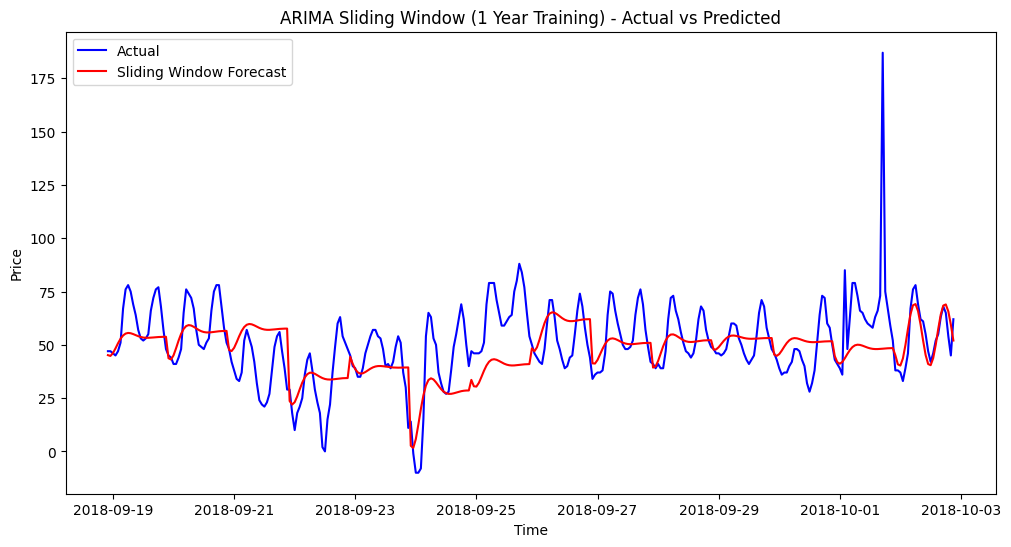

In [68]:
window_size = 24 * 365 # Keep last years data
forecast_horizon = 24 # Predict the next 24 hours
step_size = 24 # Move the window of train data by 24 hours

full_history = pd.concat([train_arima_regular, test_arima_regular])

test_start_index = len(train_arima_regular)
total_steps = len(test_arima_regular)

predictions = []
actuals = []

print(f"Starting Sliding Window Forecast (Refitting every {step_size} hours)...")
print(f"Window Size: {window_size} hours")
print(f"Test Duration: {total_steps} hours")

for t in range(0, total_steps, step_size):

    current_index = test_start_index + t

    window_start = current_index - window_size
    window_end = current_index

    train_rolling_arima = full_history.iloc[window_start : window_end]

    sliding_rolling_model = ARIMA(train_rolling_arima, order=(2, 1, 2)).fit()

    pred_values = sliding_rolling_model.forecast(steps=step_size) # Forecast

    predictions.extend(pred_values) # Store Results

    print(f"Predicted step {t}/{total_steps}")

predictions_series = pd.Series(predictions, index=test_arima_regular.index)

rmse = root_mean_squared_error(test_arima_regular, predictions_series)
mae = mean_absolute_error(test_arima_regular, predictions_series)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

plt.figure(figsize=(12, 6))
plt.plot(test_arima_regular.index, test_arima_regular, label="Actual", color="blue")
plt.plot(predictions_series.index, predictions_series, label="Sliding Window Forecast", color="red")
plt.title("ARIMA Sliding Window (1 Year Training) - Actual vs Predicted")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()

***

### 📝 Project Note: Conclusion on Vanilla ARIMA

**1. The Stability vs. Adaptability Finding**
> *"I hypothesized that a **Sliding Window** approach (training on the most recent 1 year) would outperform a **Full History** approach (training on 3+ years) by adapting to recent market regime changes (e.g., price level shifts from 2015 to 2018).
>
> However, experimental results proved the opposite:
> * **Full History (Rolling Update):** RMSE ~16.81 (Stable)
> * **Sliding Window (Daily Refit):** RMSE ~20.15 (Unstable)
>
> **Analysis:** The complex ARIMA structure (high order) requires significant data to stabilize its parameters. Reducing the training window to 1 year increased model **Variance** (instability/overfitting to noise) more than it reduced **Bias** (regime lag). Furthermore, while the *price levels* changed over the years, the underlying *autocorrelation structure* (intraday physics) remained sufficiently stable, making the older data valuable for training."*

**2. The "Univariate Ceiling"**
> *"Despite optimizing the window strategy, the Vanilla ARIMA model has reached a performance ceiling (RMSE ~16.8).
>
> **Limitations Identified:**
> * **Blindness to Fundamentals:** The model failed to predict the extreme price spike on October 2nd. This is expected, as Univariate ARIMA relies solely on past price history. It cannot see the exogenous drivers (e.g., a drop in Wind generation or a spike in Load) that caused the anomaly.
> * **Lack of Intraday Seasonality:** Without explicit time-based features, the model struggles to capture the precise hour-to-hour shape of the electricity curve (The 'Duck Curve')."*

**3. Next Steps**
> *"To break through this ceiling, I will transition to **Multivariate Models (ARIMAX / XGBoost)**. By incorporating **Exogenous Features** (Wind Generation, Load Forecast, and Time-of-Day), the model will shift from 'reacting to past price movements' to 'predicting based on fundamental market drivers'."*

***

## ARIMAX


In [ ]:
# Create a complete hourly index (using your min/max dates and timezone)
train_hourly_index = pd.date_range(
    start=train_arima.index.min(),
    end=train_arima.index.max(),
    freq="h",
    tz=train_arima.index.tz
)

test_hourly_index = pd.date_range(
    start=test_arima.index.min(),
    end=test_arima.index.max(),
    freq="h",
    tz=test_arima.index.tz
)

# Reindex your series to the train hourly index
train_arima_regular = train_arima.reindex(train_hourly_index)
test_arima_regular = test_arima.reindex(test_hourly_index)

# Fill gaps: interpolate
train_arima_regular = train_arima_regular.interpolate()    # linear interpolation
test_arima_regular = test_arima_regular.interpolate()

# Now it is fully regular: freq == 'H', ready for ARIMA and time series models
print(train_arima_regular.index.freq)
print(train_arima_regular.head(10))


In [76]:
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt


In [80]:
df_model_index = pd.date_range(
    start=df_model.index.min(),
    end=df_model.index.max(),
    freq="h",
    tz=df_model.index.tz
)

df_model_correct = df_model.reindex(df_model_index)

cols_to_interpolate = [
    "AT_load_actual_entsoe_transparency",
    "AT_price_day_ahead",
    "AT_wind_onshore_generation_actual",
    "AT_price_day_ahead_lag1",
    "AT_load_rolling24h",
    "AT_load_ema24h"
]

# Show me exactly WHICH rows have at least one NaN
nan_rows = df_model_correct[df_model_correct.isna().any(axis=1)]

print(nan_rows)
print(f"Total rows with NaNs: {len(nan_rows)}")

# df_model_correct[cols_to_interpolate] = df_model_correct[cols_to_interpolate].interpolate(method="linear")

# df_model_correct["hour"] = df_model_correct.index.hour
# df_model_correct["weekday"] = df_model_correct.index.weekday

# df_model_correct = df_model_correct.dropna()

# print(df_model_correct.head(10))
# print(df_model_correct.tail(10))
# print(df_model_correct.index)
# print(df_model_correct.isna().sum())
# print(df_model_correct.columns)

                           AT_load_actual_entsoe_transparency  \
2015-01-20 23:00:00+00:00                                 NaN   
2015-01-21 00:00:00+00:00                                 NaN   
2015-01-21 01:00:00+00:00                                 NaN   
2015-01-21 02:00:00+00:00                                 NaN   
2015-01-21 03:00:00+00:00                                 NaN   
2015-01-21 04:00:00+00:00                                 NaN   
2015-01-21 05:00:00+00:00                                 NaN   
2015-01-21 06:00:00+00:00                                 NaN   
2015-01-21 07:00:00+00:00                                 NaN   
2015-01-21 08:00:00+00:00                                 NaN   
2015-01-21 09:00:00+00:00                                 NaN   
2015-01-21 10:00:00+00:00                                 NaN   
2015-01-21 11:00:00+00:00                                 NaN   
2015-01-21 12:00:00+00:00                                 NaN   
2015-01-21 13:00:00+00:00

In [ ]:
exog_features = ["AT_load_actual_entsoe_transparency", "AT_wind_onshore_generation_actual", "hour"]
exog = df_model[exog_features]
series = df_model["AT_price_day_ahead"]

split_point = int(len(series) * 0.8)
train_series, test_series = series[:split_point], series[split_point:]
train_exog, test_exog = exog[:split_point], exog[split_point:]

print(test_series.info())

In [ ]:
order = (1,1,1)
model_sarimax = ARIMA(train_series, order=order, exog=train_exog)
model_sarimax_fit = model_sarimax.fit(disp=False)
print(model_sarimax_fit.summary())

/Users/petros/Projects/quant/quant_env/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/petros/Projects/quant/quant_env/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:     AT_price_day_ahead   No. Observations:                26257
Model:               SARIMAX(1, 1, 1)   Log Likelihood              -65573.154
Date:                Tue, 25 Nov 2025   AIC                         131158.307
Time:                        00:09:34   BIC                         131207.361
Sample:                             0   HQIC                        131174.147
                              - 26257                                         
Covariance Type:                  opg                                         
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
AT_load_actual_entsoe_transparency     0.0066   2.62e-05    252.405      0.000       0.007       0.007
AT_wind_onshore_generation_actual   5.365e-05      0.000   

In [51]:
# Reset indices to integer for modeling
train_series = train_series.reset_index(drop=True)
train_exog = train_exog.reset_index(drop=True)
test_series = test_series.reset_index(drop=True)
test_exog = test_exog.reset_index(drop=True)

# Fit model
model_sarimax = SARIMAX(train_series, order=order, exog=train_exog)
model_sarimax_fit = model_sarimax.fit(disp=False)

# Forecast
sarimax_forecast = model_sarimax_fit.forecast(steps=len(test_series), exog=test_exog)
# No need to assign datetime index at this step

print("NaNs in forecast:", sarimax_forecast.isna().sum())
print("NaNs in test_exog:", test_exog.isna().sum())

print("train_exog shape:", train_exog.shape)
print("test_exog shape:", test_exog.shape)
print("test_series shape:", test_series.shape)

print(sarimax_forecast.head(20))
print(sarimax_forecast.tail(20))


rmse_sarimax = root_mean_squared_error(test_series, sarimax_forecast)
mae_sarimax = mean_absolute_error(test_series, sarimax_forecast)
print("SARIMAX RMSE:", rmse_sarimax)
print("SARIMAX MAE:", mae_sarimax)

NaNs in forecast: 0
NaNs in test_exog: AT_load_actual_entsoe_transparency    0
AT_wind_onshore_generation_actual     0
AT_price_day_ahead_lag1               0
dtype: int64
train_exog shape: (26257, 3)
test_exog shape: (6565, 3)
test_series shape: (6565,)
26257    41.299467
26258    43.883599
26259    45.497269
26260    45.453232
26261    45.293220
26262    44.365976
26263    43.309467
26264    43.028173
26265    45.152044
26266    48.055219
26267    47.993156
26268    44.339608
26269    40.067398
26270    35.628207
26271    34.938607
26272    30.347854
26273    26.254226
26274    22.904917
26275    21.072723
26276    18.932398
Name: predicted_mean, dtype: float64
32802    22.963345
32803    28.609221
32804    38.515184
32805    49.403107
32806    53.119217
32807    52.831689
32808    50.990934
32809    48.896196
32810    46.640654
32811    44.972371
32812    42.438840
32813    41.118919
32814    41.747040
32815    43.273200
32816    45.501429
32817    47.372217
32818    44.823834
32819

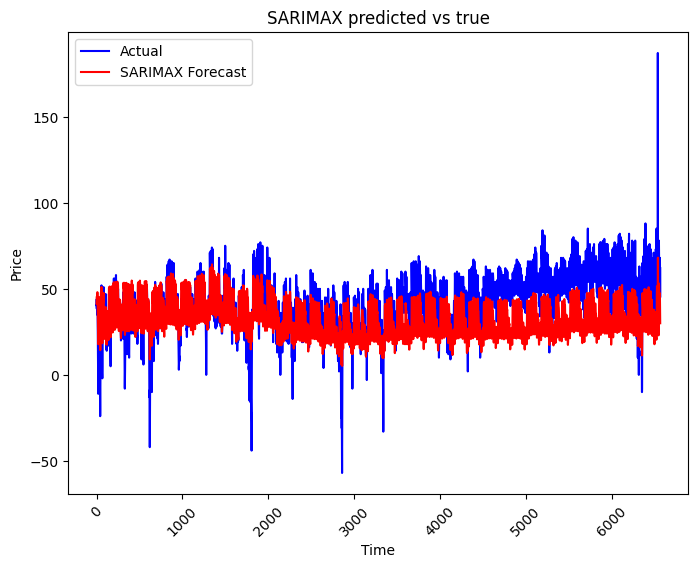

In [52]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(test_series.index, test_series, color="blue", label="Actual")
plt.plot(test_series.index, sarimax_forecast, color="red", label="SARIMAX Forecast")
plt.xticks(rotation=45)
plt.xlabel("Time")
plt.ylabel("Price")
plt.title("SARIMAX predicted vs true")
plt.legend()
plt.show()
